# Bulk Vertex Counting (VBC)

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore some messages from pandas

import pandas as pd

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

ureg = ice.ureg
idx = pd.IndexSlice


/home/leogabac/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Auxiliary functions

def plot_colloid(rawtrj):

    """ 
        For a given trajectory, returns a plot with the colloid.
        Returns a fig,axes tuple.
    """

    f, ax = plt.subplots(figsize=(5, 5));

    trj_particle = rawtrj[rawtrj.type==1]
    trj_trap = rawtrj[rawtrj.type==2]

    frame = 0
    xparticle = np.array(trj_particle.loc[idx[frame,:],"x"])
    yparticle = np.array(trj_particle.loc[idx[frame,:],"y"])
    ax.plot(xparticle,yparticle,'o', color='y')

    xtrap = np.array(trj_trap.loc[idx[frame,:],"x"])
    ytrap = np.array(trj_trap.loc[idx[frame,:],"y"])
    ax.plot(xtrap,ytrap,'o', color='g')

    ax.axis("square");
    return f,ax

def classify_vertices(vrt):
    vrt["type"] = np.NaN

    vrt.loc[vrt.eval("coordination==4 & charge == -4"),"type"] = "I"
    vrt.loc[vrt.eval("coordination==4 & charge == -2"),"type"] = "II"
    vrt.loc[vrt.eval("coordination==4 & charge == 0 & (dx**2+dy**2)==0"),"type"] = "III"
    vrt.loc[vrt.eval("coordination==4 & charge == 0 & (dx**2+dy**2)>0"),"type"] = "IV" # Dipolo
    vrt.loc[vrt.eval("coordination==4 & charge == 2"),"type"] = "V"
    vrt.loc[vrt.eval("coordination==4 & charge == 4"),"type"] = "VI"
    return vrt

def getVerticesDict(verticesFolderPath):

    """
        Walks verticesFolderPath and imports all DFs into a Dictionary, classifies the vertices and drops boundaries.
        Returns a dictionary with all the DataFrames.
    """

    _, _, files = next(os.walk(verticesFolderPath))
    verticesExp = {} # Initialize
    numberExperiments = len(files)
    for i in range(1,numberExperiments+1):
        filePath = verticesFolderPath + f"vertices{i}.csv"
        vrt = pd.read_csv(filePath, index_col=[0,1])
        vrt = classify_vertices(vrt)
        vrt = vrt.dropna()
        verticesExp[f"{i}"] = vrt
    return verticesExp

def getVerticesCount(verticesDict):
    
    """
        Loops the verticesDict with all experiments and gets the counts for vertex type
        Returns a dictionary with the counts DF for all experiments
    """

    countsDict = {}
    for key,experiment in verticesDict.items():
        currentCount = ice.count_vertices(experiment)
        countsDict[key] = currentCount
    
    return countsDict
    

In [3]:
# Import and classify the vertices
verticesFolderPath = "../data/test3/vertices/"
vertices = getVerticesDict(verticesFolderPath)
vertices["10"]

x      y  coordination  charge            dx   dy type
frame vertex                                                            
0     3       120.0  270.0             4       0  0.000000e+00  0.0  III
      4       270.0  270.0             4       0  2.000000e+00 -2.0   IV
      5       270.0  240.0             4       0  2.000000e+00 -2.0   IV
      10      270.0  210.0             4       2  2.000000e+00  0.0    V
      11      270.0  180.0             4      -2  2.000000e+00  0.0   II
...             ...    ...           ...     ...           ...  ...  ...
11995 94      240.0  210.0             4      -4  0.000000e+00  0.0    I
      95      240.0   30.0             4       0  2.000000e+00  2.0   IV
      96      240.0   60.0             4       2  1.224646e-16  2.0    V
      97       30.0   60.0             4       4  0.000000e+00  0.0   VI
      98       60.0   60.0             4      -2 -1.224646e-16 -2.0   II

[194376 rows x 7 columns]

In [4]:
counts = getVerticesCount(vertices)
counts["10"]

number  fraction
frame type                  
0     I          5  0.061728
      II        21  0.259259
      III        8  0.098765
      IV        24  0.296296
      V         20  0.246914
...            ...       ...
11995 II        21  0.259259
      III        1  0.012346
      IV        12  0.148148
      V         22  0.271605
      VI        14  0.172840

[14400 rows x 2 columns]

In [5]:
def getVerticesAverage(counts):
    
    # Get a list containing all the different frames
    allFrames = counts["1"].index.get_level_values('frame').unique().to_list()
    framespersec = 100
    time = np.array(allFrames)/framespersec
    
    numberFrames = len(allFrames)
    numberRealizations = len(counts)

    fractions = pd.DataFrame(columns=["time","I","II","III","IV","V","VI"], data = np.zeros((numberFrames,7)))

    for key,experiment in counts.items():
        for vertexType,vrt in experiment.groupby("type"):
            vertexFraction = np.array(vrt.fraction)
            fractions[vertexType] += vertexFraction

    fractions = fractions / numberRealizations
    # fractions["theta"] = time * np.pi/2/60 * (180/np.pi)
    fractions["time"] = time
    return fractions


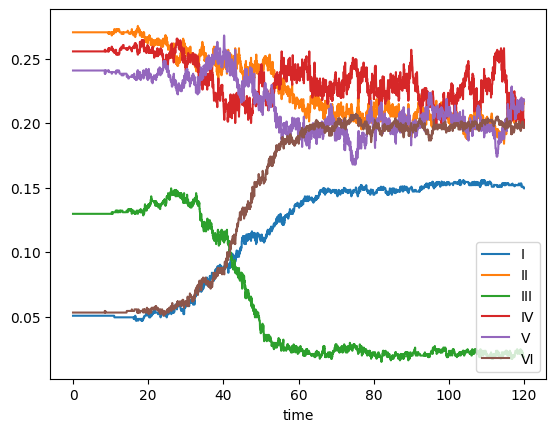

In [6]:
timeSeries = getVerticesAverage(counts)
ax = plt.gca()
types = timeSeries.columns.to_list()[1:]
for col in types:
    timeSeries.plot(kind='line',
        x='time',
        y=col,
        ax=ax
        )


In [10]:
# Separate the two dataframes into 
# Be careful with timing
rampSeries = timeSeries[timeSeries['time'] <= 60]
evoSeries = timeSeries[timeSeries['time'] > 60]

rampSeries["field"] = 5 * rampSeries["time"]/60
evoSeries["offtime"] = (evoSeries["time"]-60)
#evoSeries["angle"] = (rotationSeries["time"]-60) * np.pi/2/60 * (180/np.pi)

#rampSeries.to_csv("../data/rrot5mT60s60s/rampcounts.csv")
#evoSeries.to_csv("../data/rrot5mT60s60s/rotcounts.csv")

/tmp/ipykernel_1504/1115646704.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rampSeries["field"] = 5 * rampSeries["time"]/60
/tmp/ipykernel_1504/1115646704.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evoSeries["offtime"] = (evoSeries["time"]-60)


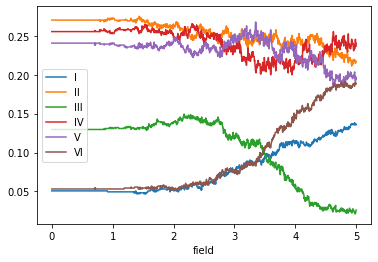

In [11]:
ax = plt.gca()
for col in types:
    rampSeries.plot(kind='line',
        x='field',
        y=col,
        ax=ax
        )

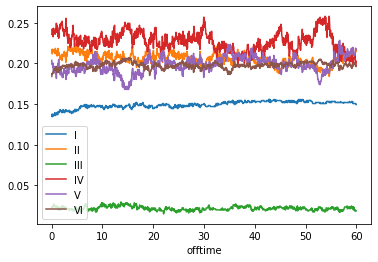

In [12]:
ax = plt.gca()
for col in types:
    evoSeries.plot(kind='line',
        x='offtime',
        y=col,
        ax=ax
        )